# Healthcare Analytics

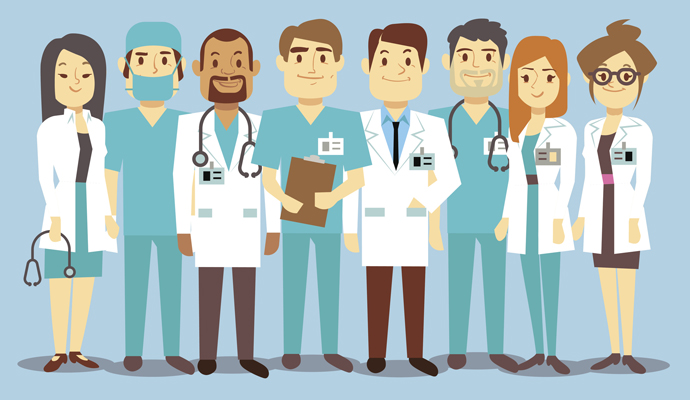


### Table of Contents

* [Pandas profiling report](#chapter1)
* [Filling null values](#section_1_1)
* [Converting categorical features into numerical](#section_1_2)
* [Choosing dependent and independent features](#section_1_2_1)
* [Preparing training data for CatBoost](#section_1_2_2)
* [Modelling](#section_1_2_3)
* [Accuracy and confusion matrix](#section_1_2_4)
* [Preparing testing data for CatBoost](#section_1_2_5)
* [Testing](#section_1_2_7)
* [Preparing output dataframe](#section_1_2_7)

In [ ]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from sklearn.model_selection import train_test_split
import xgboost as xb
import lightgbm as lbm
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
# reading the dataset

train_data = pd.read_csv('../input/av-healthcare-analytics-ii/healthcare/train_data.csv')
test_data = pd.read_csv('../input/av-healthcare-analytics-ii/healthcare/test_data.csv')
train_data.head()

#### Pandas profiling report <a class="anchor" id="chapter1"></a>

In [ ]:
profile_report = pandas_profiling.ProfileReport(train_data,minimal=True)
profile_report

#### Filling null values <a class="anchor" id="section_1_1"></a>

In [ ]:
def fill_null(df):
  df['Bed Grade'].fillna(df['Bed Grade'].value_counts().index[0],inplace=True)
  df['City_Code_Patient'].fillna(df['City_Code_Patient'].value_counts().index[0],inplace=True)

In [ ]:
# filling null values of train data

fill_null(train_data)

# filling null values of test data 

fill_null(test_data)

#### Converting categorical features into numerical <a class="anchor" id="section_1_2"></a>

In [ ]:
def convert_to_numerical(df):
  dept_list = df['Department'].unique()
  dept_list.sort()
  dept_dict = dict(zip(dept_list, range(len(dept_list))))
  df['Department'].replace(dept_dict, inplace=True)


  hrc_list = df['Hospital_region_code'].unique()
  hrc_list.sort()
  hrc_dict = dict(zip(hrc_list, range(len(hrc_list))))
  df['Hospital_region_code'].replace(hrc_dict, inplace=True)

  ward_list = df['Ward_Type'].unique()
  ward_list.sort()
  ward_dict = dict(zip(ward_list, range(len(ward_list))))
  df['Ward_Type'].replace(ward_dict, inplace=True)

  wfc_list = df['Ward_Facility_Code'].unique()
  wfc_list.sort()
  wfc_dict = dict(zip(wfc_list, range(len(wfc_list))))
  df['Ward_Facility_Code'].replace(wfc_dict, inplace=True)

  toa_list = df['Type of Admission'].unique()
  toa_list.sort()
  toa_dict = dict(zip(toa_list, range(len(toa_list))))
  df['Type of Admission'].replace(toa_dict, inplace=True)

  soi_list = df['Severity of Illness'].unique()
  soi_list.sort()
  soi_dict = dict(zip(soi_list, range(len(soi_list))))
  df['Severity of Illness'].replace(soi_dict, inplace=True)

  age_list = df['Age'].unique() 
  age_list.sort()
  age_dict = dict(zip(age_list, range(len(age_list))))
  df['Age'].replace(age_dict, inplace=True)

  htc_list = df['Hospital_type_code'].unique()
  htc_list.sort()
  htc_dict = dict(zip(htc_list, range(len(htc_list))))
  df['Hospital_type_code'].replace(htc_dict, inplace=True)

In [ ]:
# converting categorical features of train data into numerical

convert_to_numerical(train_data)

# converting categorical features of test data into numerical

convert_to_numerical(test_data)

In [ ]:
# converting categorical target feature into numerical

stay_list = train_data['Stay'].unique()
stay_list.sort()
stay_dict = dict(zip(stay_list, range(len(stay_list))))
train_data['Stay'].replace(stay_dict, inplace=True)

#### Choosing dependent and independent features <a class="anchor" id="section_1_2_1"></a>

In [ ]:
# selecting independent features and target feature

X = train_data.drop(columns=['Stay', 'case_id','patientid'])
Y = train_data['Stay']


# selecting features for test data 

test_X = test_data.drop(columns=['case_id','patientid'])

#### Preparing training data for CatBoost <a class="anchor" id="section_1_2_2"></a>

In [ ]:
# splitting into training and validation data

X_train , X_test , Y_train , Y_test = train_test_split(X,Y,test_size = 0.2 , random_state = 0)

In [ ]:
# preparing train and validation data 

train_dataset = Pool(data=X_train, label=Y_train)

eval_dataset = Pool(data=X_test, label=Y_test)

#### Modelling <a class="anchor" id="section_1_2_3"></a>

In [ ]:
# initialising catboost classifier

model = CatBoostClassifier(iterations=750,
                           learning_rate=0.08,
                           depth=7,
                           loss_function='MultiClass',
                           eval_metric='Accuracy')

In [ ]:
# fitting the model

model.fit(train_dataset)

# validation

eval_pred = model.predict(eval_dataset)

#### Accuracy and confusion matrix <a class="anchor" id="section_1_2_4"></a>

In [ ]:
# accuracy

model.get_best_score()

In [ ]:
# confusion matrix

cm = confusion_matrix(Y_test, eval_pred)
cm

#### Preparing testing data for CatBoost <a class="anchor" id="section_1_2_5"></a>

In [ ]:
# preparing test data

test_dataset = Pool(test_X)

#### Testing <a class="anchor" id="section_1_2_6"></a>

In [ ]:
# predictions on test data 

y_pred = model.predict(test_dataset)

#### Output dataframe <a class="anchor" id="section_1_2_7"></a>

In [ ]:
# preparing output dataframe

output = pd.DataFrame(test_data['case_id'].values,columns=['case_id'])
output['Stay'] = y_pred
swap_dict_stay = dict([(value, key) for key, value in stay_dict.items()])
output['Stay'].replace(swap_dict_stay, inplace=True)

In [ ]:
# saving output to csv file

output.to_csv('Healthcare_Submission.csv',index=False)